# Factor Analysis for Heritage Preservation

## Introduction
Imagine you walk into a historic library and see thousands of books scattered on the floor. To organize them, you wouldn't pick them up one by one and memorize every title. Instead, you would look for **themes**: "These are all history books," "These are all science books."

**Factor Analysis** does exactly this for your data. 

If you have 20 different variables (Temperature, Humidity, Rainfall, Soil Moisture, etc.), Factor Analysis looks for the hidden "themes" or **Factors** that connect them. It might tell you:
> "Hey, Rainfall, Humidity, and Soil Moisture all tend to go up and down together. Let's just call this group **'Moisture Stress'**."

This simplifies your life. Instead of tracking 20 variables, you only need to track 3 or 4 main factors.

In this notebook, we will:
1. **Check Suitability**: Is our data actually related enough to find patterns? (Bartlett & KMO Tests)
2. **Determine Number of Factors**: How many "themes" are there? (Scree Plot)
3. **Extract Factors**: Run the math to group the variables.
4. **Interpret Results**: Give names to our new factors.

## Why Factor Analysis Instead of PCA?

You might have heard of **Principal Component Analysis (PCA)**, which is similar to Factor Analysis. Both reduce complexity, but there's an important difference:

### PCA (Principal Component Analysis)
- **Goal**: Maximize variance explained
- **Output**: Components that are mathematical combinations of variables
- **Interpretation**: Often difficult to explain in real-world terms
- **Example**: "Component 1 = 0.42×Temperature + 0.38×Humidity - 0.29×Rainfall + ..."

### Factor Analysis (What We Use)
- **Goal**: Find interpretable factors that align with real-world processes
- **Output**: Factors with clear variable groupings (using rotation like Varimax)
- **Interpretation**: Easier to name and explain
- **Example**: "Moisture Stress Factor = high loadings on Rainfall, Humidity, Soil Moisture"

### Why This Matters for Heritage Preservation

When you present findings to:
- **Review boards**: They want to hear "moisture exposure" not "Component 1"
- **Funding agencies**: They need clear deterioration mechanisms, not mathematical abstractions
- **Preservation teams**: They need actionable categories like "thermal cycling" or "structural aging"

**Factor Analysis with rotation (Varimax)** produces factors that more clearly correspond to physical deterioration processes:
- Moisture exposure (rainfall + humidity + groundwater)
- Thermal cycling (temperature range + freeze-thaw)
- Structural aging (crack width + settlement + material loss)

This interpretability is crucial when translating statistical results into conservation strategies.

### When to Use PCA Instead

PCA is better when:
- You just want to reduce dimensions for another analysis (e.g., clustering)
- Interpretation doesn't matter—you only care about variance explained
- You're working with image data or other high-dimensional data where "themes" don't make sense

For heritage preservation decision-making, **Factor Analysis wins** because stakeholders need to understand *why* you're prioritizing certain interventions.

---

Now let's get started with the analysis!

## Step 0: Upload Your Data (Google Colab Users)

If you're running this in **Google Colab**, you need to upload the `processed_data.csv` file from Notebook 1.

**Option 1: Manual Upload**
1. Click the folder icon 📁 on the left sidebar
2. Click the upload button and select `processed_data.csv`

**Option 2: Use the code below**

In [1]:
# Uncomment the lines below if you want to upload via code
# from google.colab import files
# uploaded = files.upload()
# print("File uploaded successfully!")

In [2]:
# Install required library (only needed in Google Colab)
!pip install factor-analyzer -q

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/mljar_supervised-1.1.17-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


### Running Factor Analysis: Step-by-Step

The code below does several things. Let's break it down **before** you run it:

#### **Step 1: Import the Tool**
```python
from factor_analyzer import FactorAnalyzer
```
Gets the Factor Analysis tool from the toolbox.

#### **Step 2: Create the Model**
```python
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
```
Creates a factor analysis tool that will:
- Extract **3 factors** (you can change this number)
- Use **Varimax rotation** (makes factors easier to interpret)

**Analogy**: Setting up a camera with 3 different lenses (factors) to capture different aspects of your data.

#### **Step 3: Fit the Model**
```python
fa.fit(data_for_fa)
```
Analyzes your data to find the underlying factors.

**What happens inside** (you don't need to do this manually):
- Calculates correlations between all variables
- Finds patterns in those correlations
- Groups variables that vary together
- Rotates factors for clearer interpretation

#### **Step 4: Get the Results**
```python
loadings = fa.loadings_
```
Extracts the "loadings" — numbers showing how strongly each variable relates to each factor.

**Analogy**: Like getting a report card showing how much each student (variable) participates in each club (factor).

#### **What You'll See:**
- A table showing which variables load on which factors
- High loadings (> 0.6): Strong relationship
- Low loadings (< 0.3): Weak relationship

Now let's run the code:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Load the processed data from the previous step
try:
    df = pd.read_csv('processed_data.csv')
    print("✅ Data loaded successfully!")
    print(f"   Shape: {df.shape}")
except FileNotFoundError:
    print("❌ ERROR: 'processed_data.csv' not found.")
    print("Please run Notebook 1 (Data Preparation) first, or upload the file.")
    raise

# We only use the numerical environmental/structural variables for this analysis
# We exclude IDs (because they are just labels) and Outcomes (because we want to understand the *causes*)
fa_cols = ['Construction_Year', 'Avg_Temp_C', 'Temp_Range_C', 
           'Annual_Rainfall_mm', 'Humidity_Percent', 'Freeze_Thaw_Cycles', 
           'Soil_Moisture_Index', 'Crack_Width_mm', 'Salt_Deposition_g_m2']

X = df[fa_cols]
print(f"\nUsing {len(fa_cols)} variables for Factor Analysis")
display(X.head())

✅ Data loaded successfully!
   Shape: (200, 24)

Using 9 variables for Factor Analysis


,Construction_Year,Avg_Temp_C,Temp_Range_C,Annual_Rainfall_mm,Humidity_Percent,Freeze_Thaw_Cycles,Soil_Moisture_Index,Crack_Width_mm,Salt_Deposition_g_m2
0,0.386089,1.570802,0.516141,1.338884,0.624295,-0.274329,-2.318723e-01,0.294231,-0.011628
1,1.311530,0.590045,-0.428170,0.569362,-0.143726,0.951721,-5.700151e-16,0.440018,-1.074597
2,1.424389,-0.980576,0.236850,-0.286591,0.006744,-1.500378,-4.901498e-01,-1.657967,0.701604
3,0.363518,-0.136643,-1.413197,0.042676,-1.954333,0.338696,-1.002932e+00,-1.575499,-0.576312
4,0.972954,-0.819516,0.862341,1.154595,0.797745,-1.193866,1.351248e+00,0.574906,-0.286279


## 1. Suitability Tests

Before we start, we need to ask: "Are there actually any patterns here?"

If every variable is completely random and unrelated to the others, Factor Analysis won't work. We use two tests to check this:

1. **Bartlett's Test**: Checks if variables are correlated. We want the p-value to be **less than 0.05** (statistically significant).
2. **KMO Test (Kaiser-Meyer-Olkin)**: Measures how much overlap there is between variables. We want a score **above 0.6**.

In [4]:
# Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(X)
print(f"Bartlett's Test p-value: {p_value:.2e}")

if p_value < 0.05:
    print("✅ GOOD: The variables are related. We can proceed.")
else:
    print("❌ WARNING: The variables might not be related enough.")

# KMO Test
kmo_all, kmo_model = calculate_kmo(X)
print(f"\nKMO Score: {kmo_model:.2f}")

if kmo_model > 0.6:
    print("✅ GOOD: Data adequacy is sufficient.")
elif kmo_model > 0.5:
    print("⚠️ CAUTION: KMO score is marginal. Results may be less reliable.")
else:
    print("❌ WARNING: KMO score is too low. Factor Analysis may not be appropriate.")

Bartlett's Test p-value: 3.89e-70
✅ GOOD: The variables are related. We can proceed.

KMO Score: 0.50
⚠️ CAUTION: KMO score is marginal. Results may be less reliable.


## 2. Determining the Number of Factors (The Scree Plot)

How many factors should we look for? 2? 5? 10?

We use a **Scree Plot** to decide. 
- The Y-axis (Eigenvalue) represents how much information a factor captures.
- We look for the "elbow" of the curve—the point where the line flattens out.
- **Rule of Thumb**: Any factor with an Eigenvalue > 1 is usually worth keeping.

Eigenvalues > 1: 4 factors
Cumulative variance explained by 4 factors: 66.1%


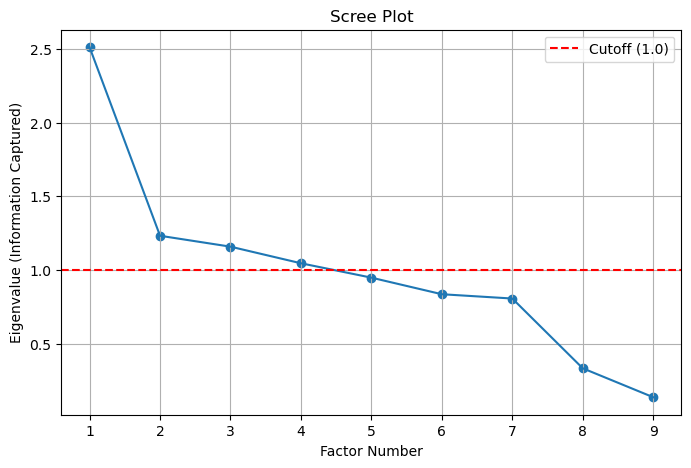


💡 Suggestion: Try 4 factors based on the eigenvalue criterion.


In [5]:
fa = FactorAnalyzer(rotation=None)
fa.fit(X)
ev, v = fa.get_eigenvalues()

# Count factors above threshold
n_factors_suggested = sum(ev > 1)
print(f"Eigenvalues > 1: {n_factors_suggested} factors")
print(f"Cumulative variance explained by {n_factors_suggested} factors: {sum(ev[:n_factors_suggested])/sum(ev)*100:.1f}%")

plt.figure(figsize=(8, 5))
plt.scatter(range(1, X.shape[1]+1), ev)
plt.plot(range(1, X.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue (Information Captured)')
plt.grid()
# Draw a red line at 1.0
plt.axhline(y=1, color='r', linestyle='--', label='Cutoff (1.0)')
plt.legend()

    plt.savefig('figures/scree_plot.png', dpi=300, bbox_inches='tight')plt.show()

print(f"\n💡 Suggestion: Try {n_factors_suggested} factors based on the eigenvalue criterion.")

## 3. Running Factor Analysis

Based on the plot above, we'll use the suggested number of factors. You can change `n_factors` below to experiment!

We use a technique called **Varimax Rotation**. Imagine rotating a map so that North is up—it makes it easier to read. Varimax rotates the mathematical factors so they are easier to interpret.

**Note on Rotation**: We use `varimax` which assumes the factors are independent (orthogonal). If you suspect your factors are strongly related (e.g. moisture and temperature often go together), you might try `rotation='promax'` (oblique rotation) in advanced analyses.

## Understanding Rotation: Varimax vs. Promax

### What is Rotation?

After extracting factors, we **rotate** them to make them easier to interpret. Think of it like rotating a 3D object to see it from the clearest angle.

Without rotation, factors often have moderate loadings on many variables, making them hard to name. Rotation creates **simple structure**: each factor loads strongly on a few variables and weakly on others.

### Two Types of Rotation

#### **Varimax Rotation (What We Use by Default)**
- **Assumes**: Factors are **uncorrelated** (independent)
- **Best for**: When deterioration mechanisms work independently
- **Example**: Moisture stress and thermal stress might affect different buildings independently
- **Advantage**: Simpler interpretation, factors don't overlap
- **Use when**: You expect distinct, separate deterioration processes

#### **Promax Rotation (Alternative)**
- **Assumes**: Factors can be **correlated** (interact)
- **Best for**: When deterioration mechanisms work together
- **Example**: Moisture and thermal stress often occur together and amplify each other
- **Advantage**: More realistic for complex heritage systems
- **Use when**: You expect factors to interact or co-occur

### Real-World Example

**Scenario**: Historic masonry deterioration

**Varimax assumption**: "Moisture damage and freeze-thaw damage are separate issues"
- Some buildings have moisture problems
- Other buildings have freeze-thaw problems
- These are independent processes

**Promax assumption**: "Moisture and freeze-thaw work together"
- Buildings with high moisture are MORE vulnerable to freeze-thaw
- These processes interact and amplify each other
- Factors should be allowed to correlate

### Which Should You Use?

**Start with Varimax** (default in this notebook) because:
- ✓ Simpler to interpret
- ✓ Easier to explain to stakeholders
- ✓ Works well in most cases

**Switch to Promax if**:
- You know deterioration mechanisms interact (e.g., moisture + temperature)
- Varimax factors seem artificial or forced
- You want to explore factor correlations
- Your domain knowledge suggests processes co-occur

### How to Use Promax Instead

In the code cell below, simply change:
```python
rotation='varimax'
```
to:
```python
rotation='promax'
```

Then you can examine factor correlations to see how much they interact:
```python
# After running Promax rotation
factor_corr = fa.phi_  # Factor correlation matrix
print("Factor Correlations:")
print(factor_corr)
```

**Interpreting factor correlations**:
- **0.0 - 0.3**: Factors are mostly independent (Varimax was fine)
- **0.3 - 0.7**: Moderate correlation (Promax is better)
- **0.7 - 1.0**: Strong correlation (factors might be measuring the same thing)

### Bottom Line

**For most heritage preservation analyses**: Use **Varimax** (default)

**For complex, interacting systems**: Try **Promax** and check if factor correlations make sense

**When in doubt**: Run both and compare! If results are similar, stick with Varimax for simplicity.

---

Now let's run the factor analysis with Varimax rotation:

Running Factor Analysis with 4 factors...

Factor Loadings:


,Factor_1,Factor_2,Factor_3,Factor_4
Construction_Year,-0.14,0.15,-0.04,0.78
Avg_Temp_C,-0.03,-0.01,0.12,0.01
Temp_Range_C,0.22,-0.01,0.97,0.11
Annual_Rainfall_mm,0.70,-0.09,-0.02,0.06
Humidity_Percent,0.21,0.97,-0.05,0.06
Freeze_Thaw_Cycles,0.01,0.04,-0.05,-0.12
Soil_Moisture_Index,0.91,0.34,-0.19,0.15
Crack_Width_mm,0.74,0.27,0.15,-0.15
Salt_Deposition_g_m2,-0.04,-0.01,-0.01,-0.09


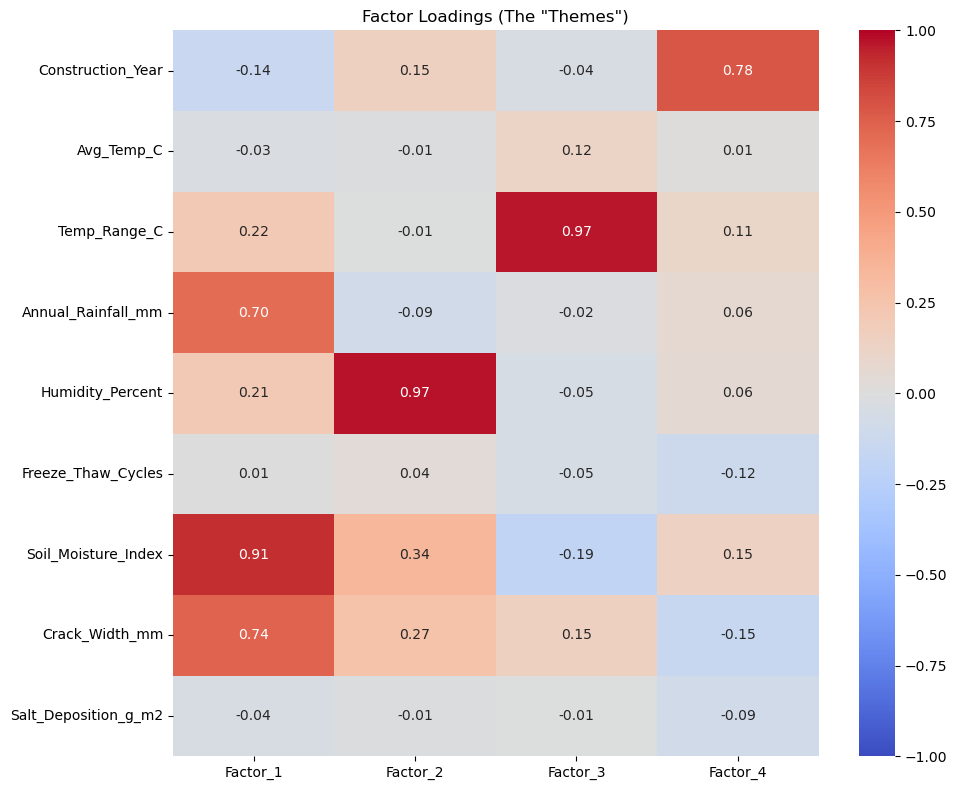

In [6]:
# You can change this number to experiment!
n_factors = n_factors_suggested  # Or set manually, e.g., n_factors = 3

print(f"Running Factor Analysis with {n_factors} factors...")
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(X)

# Get Factor Loadings
# Loadings show the correlation between the variable and the factor.
# High number (positive or negative) = Strong relationship.
# Near zero = No relationship.
loadings = pd.DataFrame(fa.loadings_, index=X.columns, columns=[f'Factor_{i+1}' for i in range(n_factors)])

print("\nFactor Loadings:")
display(loadings.round(2))

plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.2f')

    plt.title('Factor Loadings: Which variables belong to which factor?')
    plt.savefig('figures/factor_loadings.png', dpi=300, bbox_inches='tight')plt.title('Factor Loadings (The "Themes")')
plt.tight_layout()
plt.show()

### Optional: Try Promax Rotation

Want to see if your factors correlate? Run this cell to try Promax rotation and examine factor correlations:

In [7]:
# OPTIONAL: Run this cell to try Promax rotation instead
# Uncomment the code below to compare with Varimax

# from factor_analyzer import FactorAnalyzer
# 
# # Run factor analysis with Promax rotation
# fa_promax = FactorAnalyzer(n_factors=n_factors, rotation='promax')
# fa_promax.fit(data_for_fa)
# 
# # Get factor correlations
# factor_correlations = fa_promax.phi_
# 
# print("="*70)
# print("FACTOR CORRELATIONS (Promax Rotation)")
# print("="*70)
# print("\nHow much do factors correlate with each other?")
# print("(Values close to 0 = independent, close to 1 = highly correlated)\n")
# 
# # Create a nice display
# corr_df = pd.DataFrame(
#     factor_correlations,
#     columns=[f'Factor {i+1}' for i in range(n_factors)],
#     index=[f'Factor {i+1}' for i in range(n_factors)]
# )
# print(corr_df.round(3))
# 
# # Visualize factor correlations
# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='RdBu_r', 
#             center=0, vmin=-1, vmax=1, square=True)
# plt.title('Factor Correlations (Promax Rotation)', fontsize=14, fontweight='bold')
# plt.tight_layout()
# plt.show()
# 
# # Interpretation guide
# print("\n" + "="*70)
# print("INTERPRETATION")
# print("="*70)
# max_corr = corr_df.abs().values[np.triu_indices_from(corr_df.values, k=1)].max()
# print(f"\nMaximum factor correlation: {max_corr:.3f}")
# 
# if max_corr < 0.3:
#     print("✓ Factors are mostly independent → Varimax rotation is appropriate")
# elif max_corr < 0.7:
#     print("⚠ Moderate factor correlation → Promax might be more realistic")
# else:
#     print("⚠ Strong factor correlation → Consider if factors are truly distinct")
# 
# print("\n💡 TIP: If factors correlate strongly (>0.7), they might be measuring")
# print("   the same underlying process. Consider reducing the number of factors.")

## 4. Interpretation: Naming the Factors

This is where your expertise comes in! Look at the heatmap above.

**How to read it:**
Look at each column (Factor). Which variables have high numbers (dark red or dark blue)? Values above |0.6| are considered strong.

**Example Interpretation:**
- **Factor 1**: If it has high numbers for `Rainfall`, `Humidity`, and `Soil_Moisture`, we might name it **"Moisture Exposure"**.
- **Factor 2**: If it has high numbers for `Temp_Range` and `Freeze_Thaw`, we might name it **"Thermal Stress"**.
- **Factor 3**: If it has high numbers for `Crack_Width` and `Construction_Year`, we might name it **"Structural Aging"**.

Let's identify the dominant variables for each factor:

In [8]:
# Identify top variables for each factor
print("Top Variables per Factor (|loading| > 0.5):\n")
for i in range(n_factors):
    factor_name = f'Factor_{i+1}'
    top_vars = loadings[factor_name][abs(loadings[factor_name]) > 0.5].sort_values(ascending=False)
    print(f"{factor_name}:")
    if len(top_vars) > 0:
        for var, loading in top_vars.items():
            print(f"  - {var}: {loading:.2f}")
    else:
        print("  - No strong loadings (you may want to reduce the number of factors)")
    print()

Top Variables per Factor (|loading| > 0.5):

Factor_1:
  - Soil_Moisture_Index: 0.91
  - Crack_Width_mm: 0.74
  - Annual_Rainfall_mm: 0.70

Factor_2:
  - Humidity_Percent: 0.97

Factor_3:
  - Temp_Range_C: 0.97

Factor_4:
  - Construction_Year: 0.78



In [9]:
# Calculate factor scores for each building
factor_scores = pd.DataFrame(fa.transform(X), columns=[f'Factor_{i+1}' for i in range(n_factors)])

# Combine with Building ID
df_factors = pd.concat([df[['Building_ID']], factor_scores], axis=1)
print("Factor Scores for the first 5 buildings:")
display(df_factors.head())

print("\nFactor Score Statistics:")
display(factor_scores.describe())

Factor Scores for the first 5 buildings:


,Building_ID,Factor_1,Factor_2,Factor_3,Factor_4
0,B001,-0.537787,0.809253,0.615151,-0.000100
1,B002,-0.225003,-0.182943,-0.490597,0.751999
2,B003,-0.720762,0.116089,0.261185,1.375584
3,B004,-0.702445,-1.961581,-1.348817,0.395954
4,B005,1.220159,0.521348,0.497143,1.142858



Factor Score Statistics:


,Factor_1,Factor_2,Factor_3,Factor_4
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.776357e-17,1.776357e-17,-3.552714e-17,-1.998401e-17
std,1.006060e+00,1.001190e+00,9.990009e-01,8.331738e-01
min,-3.077826e+00,-2.396240e+00,-2.226541e+00,-1.645838e+00
25%,-6.034461e-01,-7.046119e-01,-6.538511e-01,-6.517883e-01
50%,3.187708e-02,2.154828e-03,-3.406531e-02,1.127426e-05
75%,6.123458e-01,6.132798e-01,6.586553e-01,7.525947e-01
max,2.163528e+00,2.345279e+00,3.030771e+00,1.620616e+00


## Saving Results

Let's save the factor scores and loadings for use in reports.

In [10]:
# Save factor scores
df_factors.to_csv('factor_scores.csv', index=False)
print("✅ Saved factor_scores.csv")

# Save factor loadings
loadings.to_csv('factor_loadings.csv')
print("✅ Saved factor_loadings.csv")

# Optional: Download files in Colab
# Uncomment to download:
# from google.colab import files
# files.download('factor_scores.csv')
# files.download('factor_loadings.csv')

✅ Saved factor_scores.csv
✅ Saved factor_loadings.csv


## Troubleshooting

**Common Issues:**

1. **"No module named 'factor_analyzer'"**: Make sure you ran the `!pip install factor-analyzer` cell at the top.
2. **Low KMO score**: Your variables may not be correlated enough. Try using only variables you suspect are related.
3. **Too many/few factors**: Experiment with different values of `n_factors`. There's no single "correct" answer.
4. **Unclear factor interpretation**: This is normal! Factor analysis is exploratory. Try different numbers of factors or rotation methods.

**Tips:**
- If factors are hard to interpret, try `rotation='promax'` instead of `'varimax'`
- Consider removing variables that don't load strongly on any factor
- Domain expertise is essential for naming factors meaningfully

## Next Steps

Now that you've identified the main factors, you can:

1. **Use factor scores in reports**: The `factor_scores.csv` file contains a score for each building on each factor.
2. **Proceed to Notebook 3**: Feature Importance Analysis to see which *individual* variables drive deterioration.
3. **Create visualizations**: Use Notebook 4 to make charts showing factor scores across buildings or districts.

**Key Takeaway**: You've reduced {len(fa_cols)} variables down to {n_factors} meaningful factors!